# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, inspired by the [Evol Instruct](https://arxiv.org/abs/2304.12244) paper.



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

In [1]:
!pip install -qU langsmith langchain-core langchain-community langchain-openai langchain-qdrant

In [2]:
!pip install -qU pymupdf ragas

We'll need to provide our LangSmith API key, and set tracing to "true".

In [3]:
import os
# import getpass

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [46]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Task 2: Loading Source Documents

In order to create a synthetic dataset, we must first load our source documents!

In [5]:
from langchain_community.document_loaders import PyMuPDFLoader

documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

## Task 3: Generate Synthetic Data

Let's first take a peek under the RAGAS hood to see what's happening when we generate a single example.

For simplicities sake - we'll look at a flow that results in a reasoning question.

### Two LLMs To Rule Them All

- `generator_llm` - will generate our seed questions and evolutions
- `critic_llm` - will act as a critic to verify if the evolutions are as we expect them to be

### Entering the Generation

We'll enter the generation process with our `generate_with_langchain_docs()` method - let's look at how that is implemented:

```python
def generate_with_langchain_docs(
    self,
    documents: t.Sequence[LCDocument],
    test_size: int,
    distributions: t.Optional[Distributions] = None,
    with_debugging_logs=False,
    is_async: bool = True,
    raise_exceptions: bool = True,
    run_config: t.Optional[RunConfig] = None,
):
    distributions = distributions or {}
    # chunk documents and add to docstore
    self.docstore.add_documents(
        [Document.from_langchain_document(doc) for doc in documents]
    )

    return self.generate(
        test_size=test_size,
        distributions=distributions,
        with_debugging_logs=with_debugging_logs,
        is_async=is_async,
        raise_exceptions=raise_exceptions,
        run_config=run_config,
    )
```

As you can see - before we do anything, our `doctore` is created using the provided `documents`.

Then, we move on to `generate()`, let's see how that works next!

### Generating Examples!

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/generator.py#L234), we'll work through the pseudo-code.

```python
function generate(test_size, distributions, other_params...):
    # Validate and set default values
    if distributions not provided:
        distributions = DEFAULT_DISTRIBUTION
    
    validate_distributions_sum_to_one(distributions)
    
    set_up_run_config()
    initialize_docstore()
    
    # Initialize evolutions
    for each evolution in distributions:
        initialize_evolution(evolution)
    
    set_up_debugging_logs_if_needed()
    
    # Set up execution environment
    executor = create_executor()
    
    # Get initial nodes
    current_nodes = get_random_nodes_from_docstore(test_size)
    
    total_evolutions = 0
    
    # Distribute evolutions based on probabilities
    for each evolution, probability in distributions:
        num_samples = round(probability * test_size)
        for i in random_sample(range(test_size), num_samples):
            submit_task_to_executor(evolution.evolve, current_nodes[i])
            total_evolutions += 1
    
    # Add filler evolutions if needed
    while total_evolutions < test_size:
        random_evolution = choose_random_evolution(distributions)
        submit_task_to_executor(random_evolution.evolve, current_nodes[total_evolutions])
        total_evolutions += 1
    
    # Get results
    try:
        test_data_rows = executor.get_results()
        if test_data_rows is empty:
            raise Exception("No results generated")

    return test_data_rows
```

In essence, we:

1. Do some validation of inputs, and initialize our evolutions.
2. Get some random nodes from our docstore.
3. Evolve the current nodes based on the desired distribution.
4. Fill with sampled evolutions if we're not at the desired number of rows.

### Peeking into the Complex Evolution Implementation for Reasoning Questions.

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L375). We'll work through the high-level implementation below.

Let's look into how the "Complex Evolution" is implemented:

1. First, we use [`_aevolve()`](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L289) to generate a "Seed Question".

```python
simple_question, current_nodes, _ = await self.se._aevolve(
            current_tries, current_nodes
        )
```

2. We use our provided `question_prompt` to generate a reasoning question.

```python
result = await self.generator_llm.generate(
            prompt=question_prompt.format(
                question=simple_question, context=merged_node.page_content
            )
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L15)):

```python
instruction="""Complicate the given question by rewriting question into a multi-hop reasoning question based on the provided context.
    Answering the question should require the reader to make multiple logical connections or inferences using the information available in given context.
    Rules to follow when rewriting question:
    1. Ensure that the rewritten question can be answered entirely from the information present in the contexts.
    2. Do not frame questions that contains more than 15 words. Use abbreviation wherever possible.
    3. Make sure the question is clear and unambiguous.
    4. phrases like 'based on the provided context','according to the context',etc are not allowed to appear in the question."""
```

3. We verify the question is valid.

```python
is_valid_question, feedback = await self.question_filter.filter(
            reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L390))

```python
instruction="""
Asses the given question for clarity and answerability given enough domain knowledge, consider the following criteria:
1.Independence: Can the question be understood and answered without needing additional context or access to external references not provided within the question itself? Questions should be self-contained, meaning they do not rely on specific documents, tables, or prior knowledge not shared within the question.
2.Clear Intent: Is it clear what type of answer or information the question seeks? The question should convey its purpose without ambiguity, allowing for a direct and relevant response.
Based on these criteria, assign a verdict of "1" if a question is specific, independent, and has a clear intent, making it understandable and answerable based on the details provided. Assign "0" if it fails to meet one or more of these criteria due to vagueness, reliance on external references, or ambiguity in intent.
Provide feedback and a verdict in JSON format, including suggestions for improvement if the question is deemed unclear. Highlight aspects of the question that contribute to its clarity or lack thereof, and offer advice on how it could be reframed or detailed for better understanding and answerability.
"""
```

4. We [handle the question](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L401) if it's not valid, otherwise we compress the question:

```python
compressed_question = await self._transform_question(
            prompt=self.compress_question_prompt, question=reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L100))

```python
instruction="""Rewrite the following question to make it more indirect and shorter while retaining the essence of the original question.
    The goal is to create a question that conveys the same meaning but in a less direct manner. The rewritten question should shorter so use abbreviation wherever possible."""
```

5. Filter the newly compressed question based on a comparison to the original simple question.

```python
if await self.evolution_filter.filter(simple_question, compressed_question):
            # retry
            current_nodes = self.se._get_new_random_node()
            logger.debug(
                "evolution_filter failed, retrying with %s", len(current_nodes.nodes)
            )
            return await self.aretry_evolve(current_tries, current_nodes)
```

`filter` is implemented as follows, with our Critic LLM:

```python
    async def filter(self, simple_question: str, compressed_question: str) -> bool:
        prompt = self.evolution_elimination_prompt.format(
            question1=simple_question, question2=compressed_question
        )
        results = await self.llm.generate(prompt=prompt)
        results = results.generations[0][0].text.strip()
        results = await evolution_elimination_parser.aparse(results, prompt, self.llm)
        results = results.dict() if results is not None else {}
        logger.debug("evolution filter: %s", results)
        return results.get("verdict") == 1
```

Let's zoom back out now!



### Generating Answers:

For answer generation, we simply ask the LLM to answer the question we evolved using the context associated with our evolution - that's it!

We will this:

```python
class AnswerFormat(BaseModel):
    answer: str
    verdict: int
```

Using [this prompt](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L143):

```python
instruction="""Answer the question using the information from the given context. Output verdict as '1' if answer is present '-1' if answer is not present in the context."""
```

This uses our Generator LLM.

Actually creating our Synthetic Dataset is as simple as running the following cell!

In [6]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

generator_llm = AzureChatOpenAI(model="gpt-4o-mini")
critic_llm = AzureChatOpenAI(model="gpt-4")
embeddings = AzureOpenAIEmbeddings(azure_deployment="text-embedding-3-large")

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

#### ❓ Question #1:

What do the distributions do *specifically*?

> NOTE: More information is available [here](https://docs.ragas.io/en/latest/concepts/testset_generation.html#in-depth-evolution) on the evolution distributions.

#### ✔️ Answer Question #1:

The distributions in the context provided refer to the specific proportions of different types of questions generated for the evaluation dataset. Here’s what each type of question does specifically:

1. **Simple**: Basic questions that do not require complex reasoning or multiple pieces of information to answer. These are straightforward questions derived directly from the documents.

2. **Multi-Context**: These questions are designed to require information from multiple related sections or chunks of the documents. They are crafted to ensure that the answer is not found in a single location but dispersed across different parts of the document.

3. **Reasoning**: Questions that are rewritten to enhance the need for reasoning. These questions are more complex and require the model to apply logical thinking and inference to arrive at the correct answer.

Let's generate!

> NOTE: This cell will take some time, and also make a lot of calls to OpenAI's endpoints! You may run into rate-limits during this cell!

In [7]:
testset = generator.generate_with_langchain_docs(documents, 20, distributions, with_debugging_logs=True)

embedding nodes:   0%|          | 0/64 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/20 [00:00<?, ?it/s]

[ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 2, 'structure': 3, 'relevance': 3, 'score': 2.75}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Timothy D. Cook', 'Luca Maestri', 'Sarbanes-Oxley Act of 2002', 'Quarterly Report of Apple Inc.', 'Securities Exchange Act of 1934']
[ragas.testset.filters.DEBUG] context scoring: {'clarity': 2, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 2.75}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['European Commission State Aid Decision', 'Irish corporate income taxes', 'Commercial paper program', 'Share repurchase program', 'General Court of the Court of Justice of the European Union']
[ragas.testset.filters.DEBUG] context scoring: {'clarity': 2, 'depth': 3, 'structure': 2, 'relevance': 3, 'score': 2.5}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Digital Markets Act investigations', 'U.S. Department of Justice lawsuit', 'Epic Games lawsuit', 'Antitrust laws', 'Compliance 

#### 🏗️ Activity #1:

Using the dubgging logs above - trace through a single example of an evolution.

Mark which LLM (Generator, or Critic) was responsible for each step.

#### ✔️ Answer  Activity #1:

##### Example of an Evolution Trace

1. **Initial Context Scoring**:
   - Critic LLM:
     ```plaintext
     [ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 2, 'structure': 3, 'relevance': 3, 'score': 2.75}
     ```

2. **Keyphrase Extraction**:
   - Generator LLM:
     ```plaintext
     [ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Timothy D. Cook', 'Luca Maestri', 'Sarbanes-Oxley Act of 2002', 'Quarterly Report of Apple Inc.', 'Securities Exchange Act of 1934']
     ```

3. **Seed Question Generation**:
   - Generator LLM:
     ```plaintext
     [ragas.testset.evolutions.INFO] seed question generated: "What is the role of Timothy D. Cook in the certification of Apple Inc.'s Quarterly Report?"
     ```

4. **Question Filtering**:
   - Critic LLM:
     ```plaintext
     [ragas.testset.filters.DEBUG] filtered question: {'feedback': "The question asks for the role of Timothy D. Cook in the certification of Apple Inc.'s Quarterly Report. It is specific, independent, and has a clear intent, making it understandable and answerable based on the details provided. The question does not rely on external references or additional context, and it clearly seeks information about Timothy D. Cook's involvement in a specific aspect of Apple Inc.'s operations.", 'verdict': 1}
     ```

5. **Evolution Type Determination**:
   - Generator LLM:
     ```plaintext
     [ragas.testset.evolutions.DEBUG] [MultiContextEvolution] simple question generated: "What is the role of Timothy D. Cook in the certification of Apple Inc.'s Quarterly Report?"
     ```

6. **Evolution and Rewriting**:
   - Generator LLM:
     ```plaintext
     [ragas.testset.evolutions.DEBUG] [MultiContextEvolution] multicontext question generated: "What certifications does Timothy D. Cook provide regarding the accuracy and compliance of Apple Inc.'s quarterly financial report, and what responsibilities does he assume in relation to internal controls?"
     [ragas.testset.evolutions.DEBUG] [MultiContextEvolution] multicontext question compressed: "What certs does Tim Cook have for Apple's quarterly report accuracy and his role in internal controls?"
     ```

In [8]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What was the change in iPhone net sales during...,[Products and Services Performance\nThe follow...,iPhone net sales were relatively flat during t...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
1,What was the total change in unrealized gains/...,[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...,The total change in unrealized gains/losses on...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
2,What factors can materially and adversely affe...,"[ ended March 30, 2024 (the “second quarter 20...",The context mentions that the Company's busine...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
3,What were the cash used in financing activitie...,[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...,Cash used in financing activities for Apple In...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
4,What types of exhibits are included in the App...,[Item 6. \nExhibits\nIncorporated by Reference...,The types of exhibits included in the Apple In...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
5,What allegations were made by Epic Games in th...,[PART II — OTHER INFORMATION\nItem 1. \nLega...,Epic Games alleged violations of federal and s...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
6,What is the total amount of manufacturing purc...,"[Selling, General and Administrative\nSelling,...",The total amount of manufacturing purchase obl...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
7,What impact do product introductions have on t...,[Item 2. \nManagement’s Discussion and Analysi...,New product and service introductions can sign...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
8,What was the total change in unrealized gains/...,[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...,The total change in unrealized gains/losses on...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
9,What is the total fair value of the Company's ...,"[September 30, 2023\nAdjusted\nCost\nUnrealize...",The total fair value of the Company's marketab...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True


# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [9]:
from langsmith import Client

client = Client()

dataset_name = "Apple 10-Q Filing Questions - v3"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about Apple's 10-Q Filing"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [10]:
for test in testset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": test[1]["question"]
      },
      outputs={
          "answer": test[1]["ground_truth"]
      },
      metadata={
          "context": test[0]
      },
      dataset_id=dataset.id
  )

## Basic RAG Chain

Time for some RAG!

We'll use the Apple 10-Q filing as our data source today!


In [11]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [13]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(azure_deployment="text-embedding-3-large")

As usual, we will power our RAG application with Qdrant!

In [14]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q"
)

In [15]:
retriever = vectorstore.as_retriever()

To get the "A" in RAG, we'll provide a prompt.

In [16]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [17]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(azure_deployment="gpt-4")

Finally, we can set-up our RAG LCEL chain!

In [18]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [69]:
rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

'Based on the provided context, Apple seems to be in good financial health. Here are some key indicators:\n\n1. **Net Income**: For the nine months ended June 29, 2024, Apple reported a net income of $79,000 million, compared to $74,039 million for the same period in 2023.\n2. **Total Net Sales**: For the nine months ended June 29, 2024, total net sales were $296,105 million, compared to $293,787 million for the same period in 2023.\n3. **Cash and Cash Equivalents**: As of June 29, 2024, Apple had cash and cash equivalents of $25,565 million.\n4. **Marketable Securities**: As of June 29, 2024, Apple had marketable securities worth $36,236 million.\n5. **Total Current Assets**: As of June 29, 2024, total current assets were $125,435 million.\n\nThese figures suggest strong profitability and liquidity, indicating good financial health.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [20]:
eval_llm = AzureChatOpenAI(azure_deployment="gpt-4")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [23]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "llm" : eval_llm, # added llm config so that it calls Azure instead of OpenAI API by default
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "llm" : eval_llm, # added llm config so that it calls Azure instead of OpenAI API by default
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        }
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: This evaluator is set up to evaluate question-answering (QA) performance. It uses a language model (LLM) specified in the `config` to assess the quality of the answers provided. It evaluates the accuracy and quality of question-answering.

- `labeled_helpfulness_evaluator`: This evaluator is configured to evaluate the helpfulness of a submission. Specifically, it checks if the submission is helpful to the user by comparing it to the correct reference answer. The preparation of data involves extracting the prediction, reference answer, and input question from the provided run and example. It evaluates the helpfulness of the submission in relation to the reference answer.

- `dope_or_nope_evaluator`: This evaluator is set up to evaluate the "dopeness" of a submission. It checks whether the submission is considered dope, lit, or cool based on the specified criteria. It evaluates the coolness or appeal of the submission based on subjective criteria.

## LangSmith Evaluation

In [25]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain"},
)

View the evaluation results for experiment: 'abandoned-start-99' at:
https://smith.langchain.com/o/7be4a3d4-3e9e-5115-942b-127a533b3467/datasets/a0e06d63-e559-426d-b04b-b69ea4cc1e72/compare?selectedSessions=13c13441-d280-42b1-9b14-07f861443770




0it [00:00, ?it/s]

<ExperimentResults abandoned-start-99>

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [26]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [27]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

#### ✔️ Answer Question #2:

- Larger chunks capture more semantic meaning, preserve more context, and have less chance that some information ends up being split in separate chunks. For instance, you do not want to split a table in the middle as the heading would end up in one chunk and the body without heading would be in the other chunk. Therefore, the second chunk becomes meaningless.
- Larger chunks reduce database size, because the total text size of all chunks stays the same but the space for embeddings is considerably less. The embeddings are by factors larger than chunk size, therefore, you save when the number of embedding stored is fewer.
- The search through a vector database is faster since there are fewer embeddings you need to perform cosine similarity comparison.
- However, the cost may go up if we have to supply the same number of chunks to an LLM for generation, therefore, increasing prompt token size. It will also increase latency.

In [29]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(azure_deployment="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

#### ✔️ Answer Question #3:

- A larger and better embedding model especially as judged by embedding models comparison charts (say by HuggingFace) is most probably trained on a larger dataset and therefore is able to better capture semantic meaning.
- Fine-tuned or subject specific embedding models can better handle text on specific subjects.
- Smaller embedding models may decrease our performance but may also significantly save memmory/storage as they usually use fewer dimentions. On the other hand, bigger and supposedly better models increase storage costs.
- Some bigger models also have bigger context window, so they are able to vectorize/embed bigger chunks (32k token and more).

In [30]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q (Augmented)"
)

In [31]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [32]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [33]:
dope_rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

'Yo, from the vibes of those numbers, Apple’s looking pretty solid. They’ve got some serious cash flow, net income is up, and their assets are no joke. Plus, they’re pulling in major sales and keeping costs in check. So yeah, Apple seems to be in good financial health.'

Finally, we can evaluate the new chain on the same test set!

In [34]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'memorable-wood-66' at:
https://smith.langchain.com/o/7be4a3d4-3e9e-5115-942b-127a533b3467/datasets/a0e06d63-e559-426d-b04b-b69ea4cc1e72/compare?selectedSessions=9b240a0d-3735-4ee8-90ae-aac70e52ce01




0it [00:00, ?it/s]

<ExperimentResults memorable-wood-66>

#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

#### ✔️ Answer Activity #3:

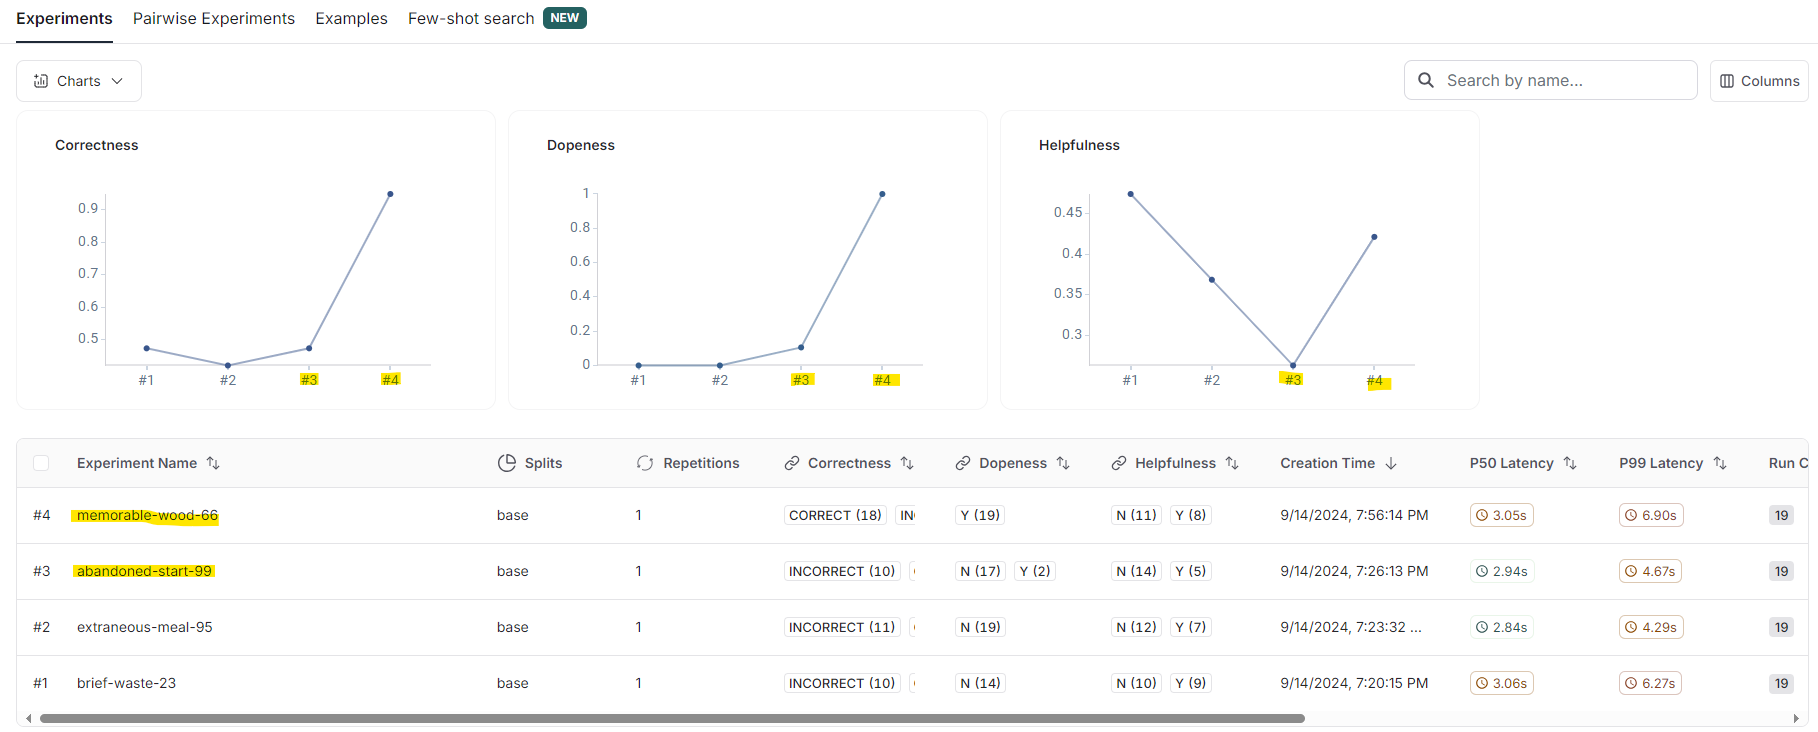


- Because I already used a large embedding model by OpenAI before, it did not have impact in this example. Otherwise, I would assume that a large model should have produced a better result. (I do not have a small embedding model in my Azure region deployment, so I had to use a large model instead).
- We can see that with the dopeness RAG chain, the correctness increased significantly. I attribute it to the bigger chunk size and bigger overlap, since the embedding model is the same and prompt is essentially the same in terms of factually answering the question.
- Because we were able to increase correctness by increasing the chunks size, therefore, it directly contributed to the increase in helpfulness of the answer. Incorrect answers are not helpful, are they?
- And lastly, because the dopeness RAG chain prompt specifically instructs to answer questions in the dope way, we are seeing a 100% hit rate. Bulls eye!